# Import data and libs

In [1]:
import os
import re
import pickle
import nltk, string
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from indoNLP.preprocessing import *
from tqdm.notebook import tqdm

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [3]:
# Configs
SEED = 42

# Import Data

In [4]:
data1 = '../dataset/scraped-somethinc-niacinamide.csv'
df1 = pd.read_csv(data1)
print(df1.shape)
df1.columns

(1000, 5)


Index(['Tanggal', 'Username', 'Rekomendasi', 'Review', 'Informasi Tambahan'], dtype='object')

In [5]:
data2 = '../dataset/scraped-the-ordinary-niacinamide.csv'
df2 = pd.read_csv(data2)
print(df2.shape)
df2.columns

(266, 4)


Index(['Tanggal', 'Username', 'Rekomendasi', 'Review'], dtype='object')

In [6]:
data3 = '../dataset/scraped-somethinc-niacinamide.csv'
df3 = pd.read_csv(data3)
print(df3.shape)
df3.columns

(1000, 5)


Index(['Tanggal', 'Username', 'Rekomendasi', 'Review', 'Informasi Tambahan'], dtype='object')

In [7]:
df1.drop(['Informasi Tambahan'], axis=1,inplace=True)
df1.columns

Index(['Tanggal', 'Username', 'Rekomendasi', 'Review'], dtype='object')

In [8]:
df3.drop(['Informasi Tambahan'], axis=1,inplace=True)
df3.columns

Index(['Tanggal', 'Username', 'Rekomendasi', 'Review'], dtype='object')

In [9]:
df = pd.concat([df1, df2, df3])
df.shape

(2266, 4)

In [10]:
df.head()

,Tanggal,Username,Rekomendasi,Review
0,4 days ago,rxzka,rxzka recommends this product!,Aku dapet beberapa samplenya dari event make u...
1,4 days ago,Aisyiyah,Aisyiyah recommends this product!,Somethinc Niacinamide + Moisture Sabi Beet Bri...
2,14 Oct 2024,intanWA26,intanWA26 recommends this product!,Aku pake ini untuk pagi hari dibarengi sunscre...
3,10 Oct 2024,amdchr,amdchr recommends this product!,Bener-bener ngefek banget di aku.. Kalo ada PI...
4,30 Sep 2024,nysrinaw,nysrinaw recommends this product!,been using this product lumayan beberapa kali ...


In [11]:
df['Rekomendasi'].unique()

array(['rxzka recommends this product!',
       'Aisyiyah recommends this product!',
       'intanWA26 recommends this product!', ...,
       'Fairlya recommends this product!',
       'auliafps recommends this product!',
       "sba_1883 doesn't recommend this product! "], dtype=object)

In [12]:
df.drop_duplicates()
df.shape

(2266, 4)

In [13]:
df.dropna(inplace=True)
df.shape

(2214, 4)

# Data Preprocessing

In [14]:
def RekomendasiToSentiment(row):
  if ('recommends' in row['Rekomendasi']):
    return 1
  else:
    return 0

df['Sentiment'] = df.apply(RekomendasiToSentiment, axis=1)

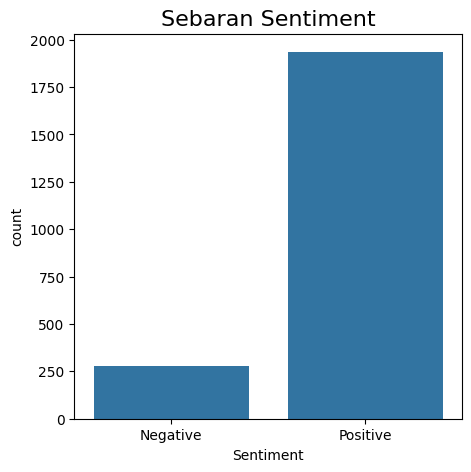

In [15]:
plt.figure(figsize=(5, 5))
sns.countplot(data=df, x="Sentiment")
plt.title("Sebaran Sentiment", fontsize=16)
plt.xticks([0, 1], ["Negative", "Positive"])
plt.show()

In [38]:
def get_stopwords(file_path):
  stopwords=[]
  file_stopwords = open(file_path,'r')
  row = file_stopwords.readline()
  while row:
      word = row.strip()
      stopwords.append(word)
      row = file_stopwords.readline()
  file_stopwords.close()
  return stopwords

def handle_stopwords(review, stopwords):
  feature_vector = []
  review = review.split(' ')
  for word in review:
    val = re.search(r"^[a-zA-Z][a-zA-Z0-9]*$", word) #menghilangkan karakter selain huruf didalam kata
    if (word in stopwords or val is None):
      continue
    elif (word == 'enggak'):
      feature_vector.append('tidak')
    else:
      feature_vector.append(word)
  for_stemming = ' '.join(feature_vector)
  return feature_vector, for_stemming

def handle_negative(review):
  negative_review = []
  review = review.split(' ')
  for i in range(len(review)):
    word = review[i]
    if i == 0 or (review[i-1] != 'enggak' and review[i-1] != 'tidak'):
      negative_review.append(word)
    else:
      negative_review.pop()
      word = 'tidak_'+word
      negative_review.append(word)
  for_stemming = ' '.join(negative_review)
  return for_stemming

In [42]:
import sys

# setting path
sys.path.append('../../dataset')

from dataset.slang_data import SLANG_DATA
def handle_slang(text):
  SLANG_PATTERN = rf"(?i)\b({'|'.join(SLANG_DATA.keys())})\b"
  return re.sub(SLANG_PATTERN, lambda mo: SLANG_DATA[mo.group(0).lower()], text)

In [44]:
# Remove emoji, punctuation, symbol
def preprocess(text):
  # Casefolding to Lowercase
  text = text.lower()

  # Remove punctuation
  text = text.translate(str.maketrans('', '', string.punctuation))

  text = replace_word_elongation(text)  # replace WE

  # Change emoji to words
  # text = emoji_to_words(text)
  text = text.translate(str.maketrans(string.punctuation, " " * len(string.punctuation)))

  # Remove HTML tags
  text = remove_html(text) 
  text = remove_url(text)  # remove url
  # text = replace_slang(text)  # replace slang words
  text = handle_slang(text)
  
  # Remove numbers
  text = text.translate(str.maketrans('', '', string.digits))

  file_path ='../dataset/stopwords-indo.txt'
  stopwords = get_stopwords(file_path)
  feature, text = handle_stopwords(text, stopwords)

  # Remove whitespaces at front and back
  text = ' '.join(text.split())

  # Stemming
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  text = stemmer.stem(text)
  text = handle_negative(text)
  return text


In [45]:
test = preprocess("ga cocok di aku, tidak direkomen, esoknya jelek, so far so good")
print(test)

tidak_cocok tidak_direkomen esok jelek so far so good


In [46]:
df["Cleaned"] = [preprocess(x) for x in tqdm(df['Review'].values)]

  0%|          | 0/2214 [00:00<?, ?it/s]

In [47]:
vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=3000)
x = vectorizer.fit_transform(df['Cleaned'].values)

In [48]:
df.head()

,Tanggal,Username,Rekomendasi,Review,Sentiment,Cleaned
0,4 days ago,rxzka,rxzka recommends this product!,Aku dapet beberapa samplenya dari event make u...,1,samplenya event pakai up clas somethinc kerjas...
1,4 days ago,Aisyiyah,Aisyiyah recommends this product!,Somethinc Niacinamide + Moisture Sabi Beet Bri...,1,somethinc niacinamide moisture sabi beet brigh...
2,14 Oct 2024,intanWA26,intanWA26 recommends this product!,Aku pake ini untuk pagi hari dibarengi sunscre...,1,pakai pagi bareng sunscreenkandungan niacinami...
3,10 Oct 2024,amdchr,amdchr recommends this product!,Bener-bener ngefek banget di aku.. Kalo ada PI...,1,benerbener ngefek banget kalo pih butuh langsu...
4,30 Sep 2024,nysrinaw,nysrinaw recommends this product!,been using this product lumayan beberapa kali ...,1,been using this product lumayan kali pas launc...


# Insight from Data - WordCloud

In [49]:
data = df

In [50]:
nama_fitur = vectorizer.get_feature_names_out()
index_p = data["Cleaned"][data["Sentiment"] == 1].index
index_n = data["Cleaned"][data["Sentiment"] == 0].index
positif = x[index_p]
negatif = x[index_n]

In [51]:
def finder(words):
  top_kata = {}
  for i in range(words.shape[0]):
    row = words.getrow(i).toarray()[0]
    max_ = np.argmax(row)
    if nama_fitur[max_] in top_kata:
      top_kata[nama_fitur[max_]] += 1
    else:
      top_kata[nama_fitur[max_]] = 1
  return top_kata

top_positif = finder(positif)
top_negatif = finder(negatif)

In [52]:
# Sorting
top_positif = {k: v for k, v in sorted(top_positif.items(), key=lambda item: item[1], reverse=True)}
top_negatif = {k: v for k, v in sorted(top_negatif.items(), key=lambda item: item[1], reverse=True)}

In [53]:
from wordcloud import WordCloud

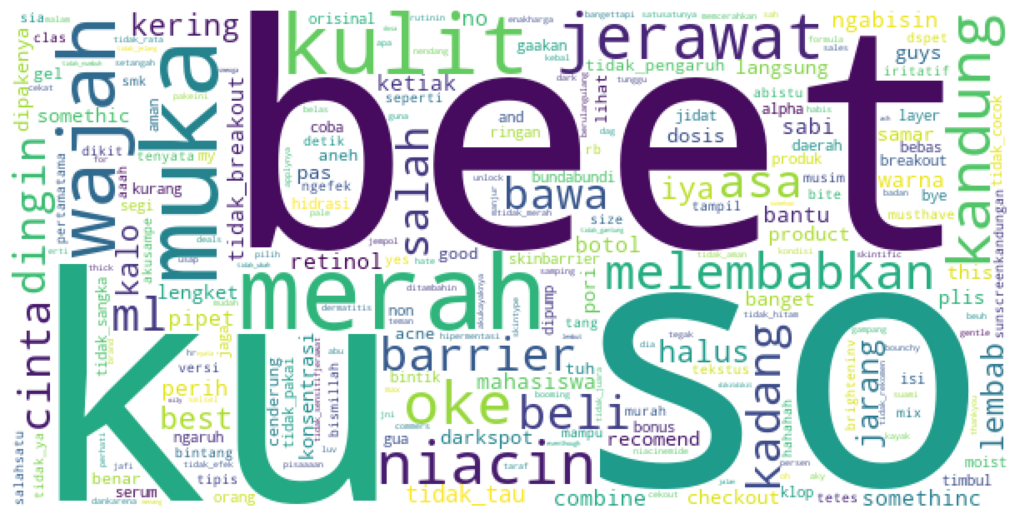

In [54]:
# WordCloud kata dengan bobot terbesar Positif
w = WordCloud(
    width=600,
    height=300,
    colormap="viridis",
    mode="RGBA",
    stopwords=STOPWORDS,
    background_color="white",
    max_words=5000,
    random_state=SEED,
).fit_words(top_positif)

plt.figure(figsize=(10, 10), facecolor=None)
plt.imshow(w)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

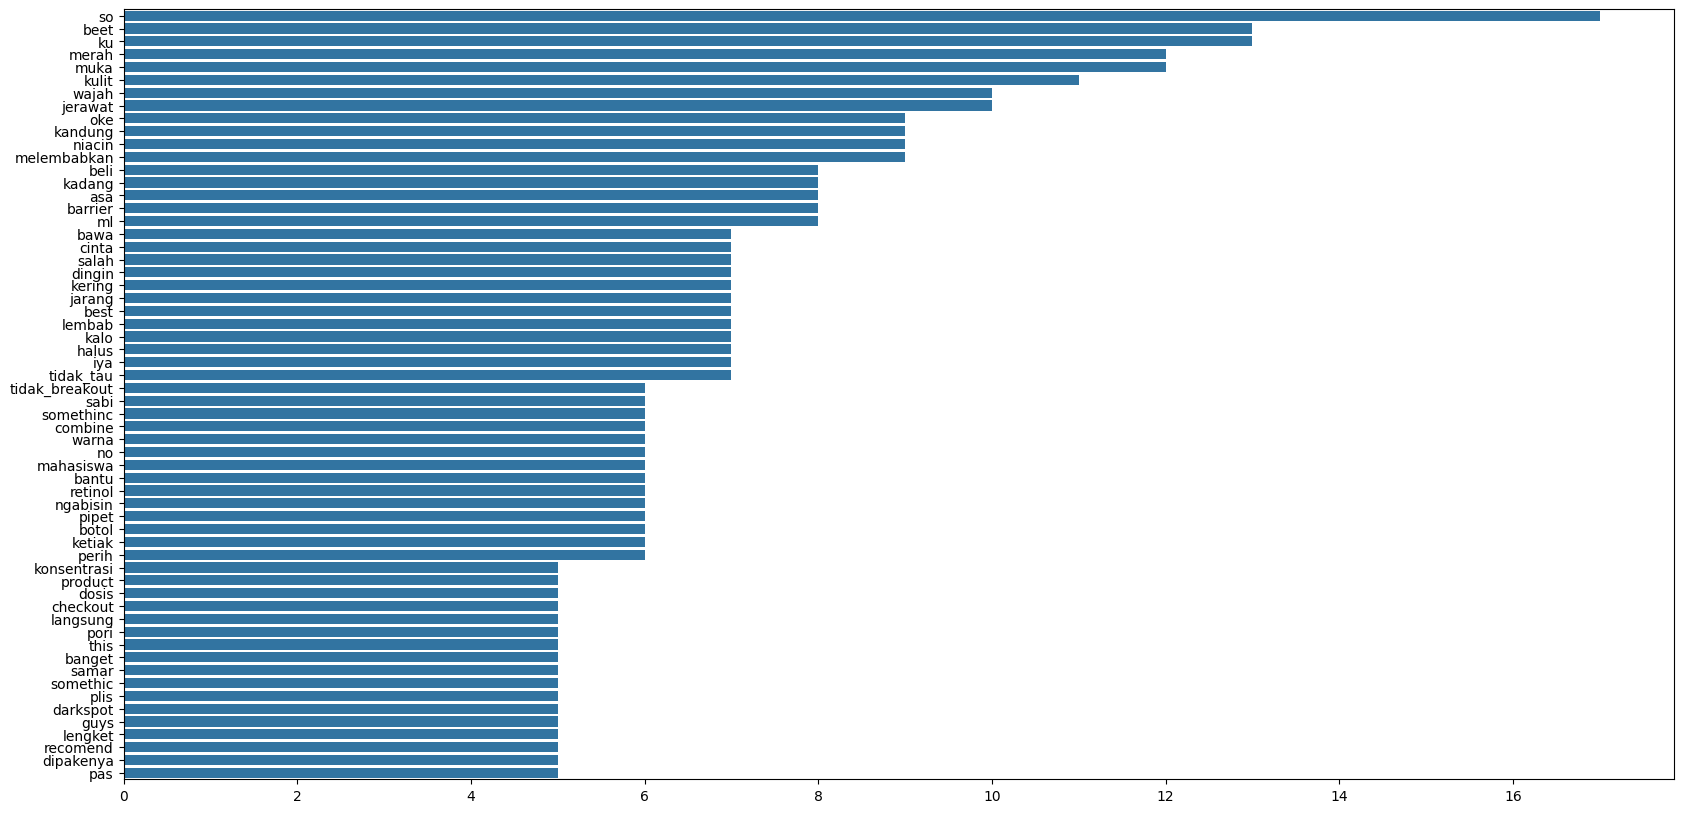

In [55]:
# Show most frequent words in a bar graph
word_list, count_list = [], []
counter = 0
for word, count in top_positif.items():
    if (counter == 60):
        break
    word_list.append(word)
    count_list.append(count)
    counter += 1
plt.figure(figsize=(20, 10))
sns.barplot(x=count_list, y=word_list)
plt.show()

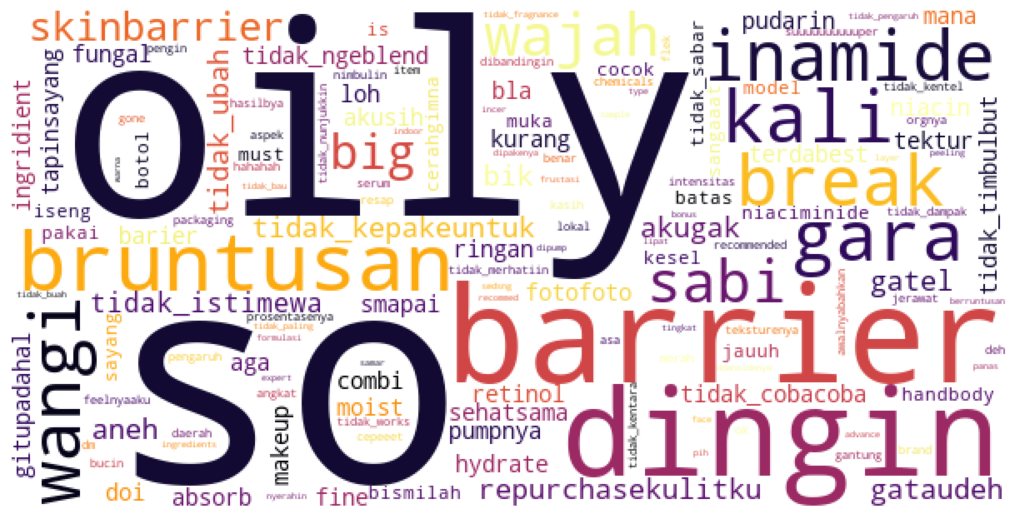

In [56]:
# WordCloud kata dengan bobot terbesar negatif
w = WordCloud(
    width=600,
    height=300,
    mode="RGBA",
    stopwords=STOPWORDS,
    colormap="inferno",
    background_color="white",
    max_words=5000,
    random_state=SEED,
).fit_words(top_negatif)

plt.figure(figsize=(10, 10), facecolor=None)
plt.imshow(w)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

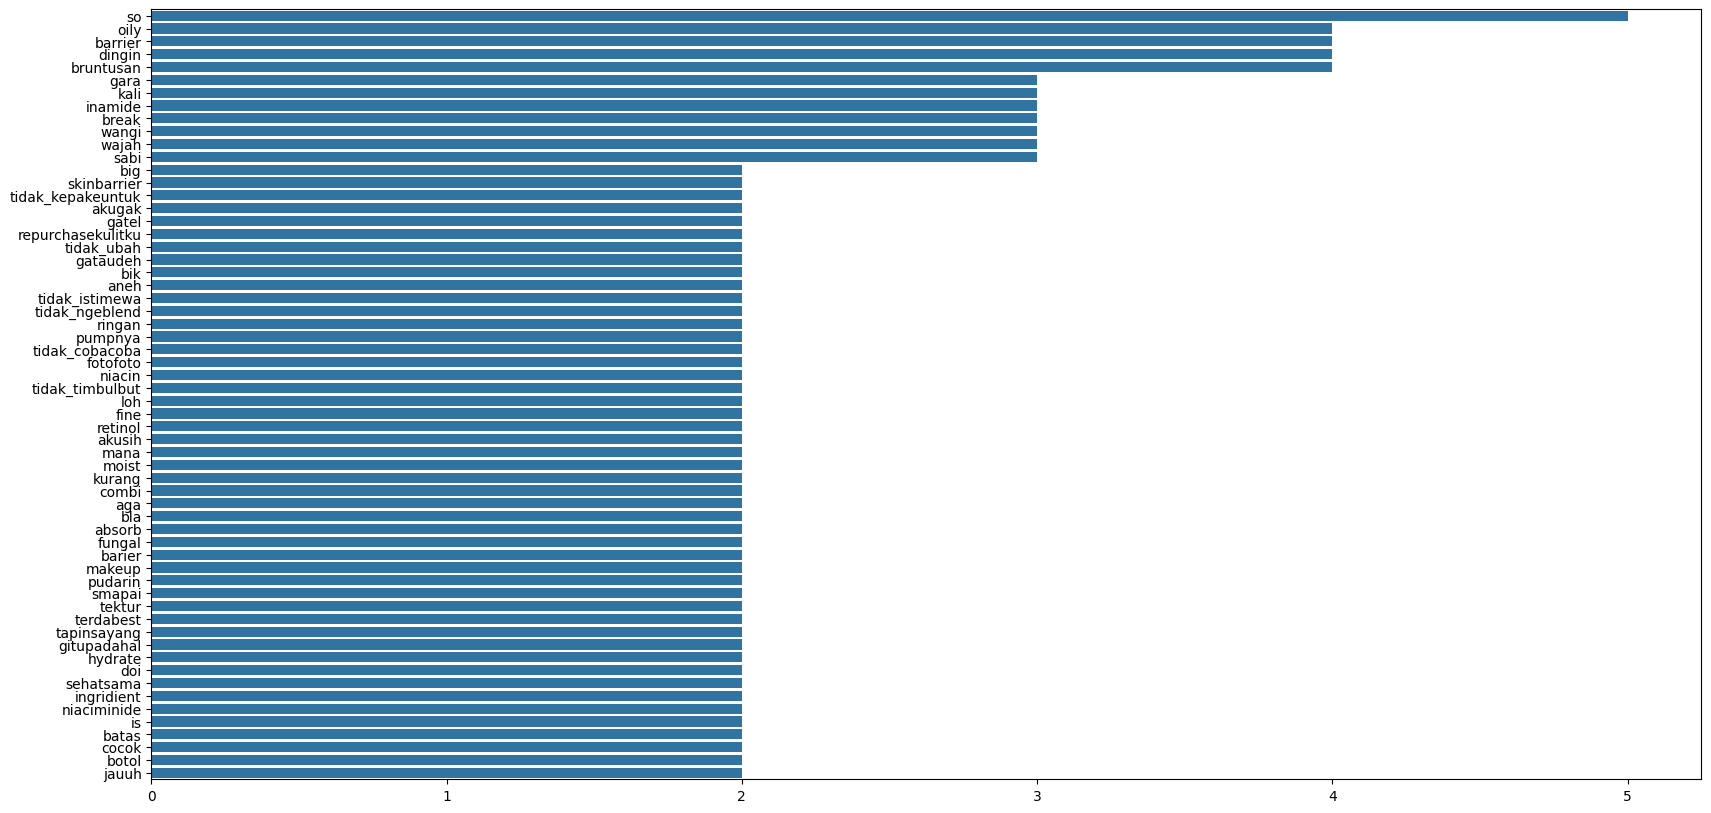

In [57]:
# Show most frequent words in a bar graph
word_list, count_list = [], []
counter = 0
for word, count in top_negatif.items():
    if (counter == 60):
        break
    word_list.append(word)
    count_list.append(count)
    counter += 1
plt.figure(figsize=(20, 10))
sns.barplot(x=count_list, y=word_list)
plt.show()

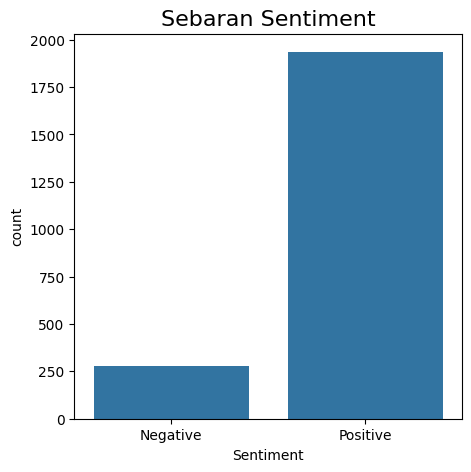

In [59]:
plt.figure(figsize=(5, 5))
sns.countplot(data=df, x="Sentiment")
plt.title("Sebaran Sentiment", fontsize=16)
plt.xticks([0, 1], ["Negative", "Positive"])
plt.show()

# Data Augmentation

In [60]:
# Test combination sampling to handle imbalance data
from imblearn.combine import SMOTEENN
from collections import Counter

print('Initial:', Counter(data['Sentiment']))

from imblearn.combine import SMOTETomek
smote_tomek = SMOTEENN(random_state=0)
x_resampled, y_resampled = smote_tomek.fit_resample(x, data['Sentiment'])
print('SMOTE ENN:', sorted(Counter(y_resampled).items()))
# [(0, 1540), (1, 1559), (2, 1542)] 

smote_tomek = SMOTETomek(random_state=0)
x_resampled, y_resampled = smote_tomek.fit_resample(x, data['Sentiment'])
print('SMOTE TOMEK:', sorted(Counter(y_resampled).items()))
# [(0, 1540), (1, 1559), (2, 1542)] 

Initial: Counter({1: 1935, 0: 279})
SMOTE ENN: [(0, 1926), (1, 1713)]
SMOTE TOMEK: [(0, 1935), (1, 1935)]


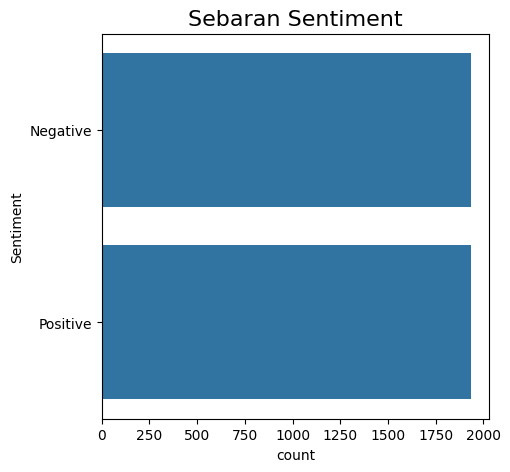

In [61]:
# Pasca imbalance
plt.figure(figsize=(5, 5))
sns.countplot(y=y_resampled)
plt.title("Sebaran Sentiment", fontsize=16)
plt.yticks([0, 1], ["Negative", "Positive"])
# plt.xticks([0, 1], ["Negative", "Positive"])
plt.show()

# Choosing Model

In [62]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [63]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import LinearSVC

In [64]:
# Model before the Data Augmentation
cv = StratifiedKFold(shuffle=True, random_state=SEED)

classifiers = {
    "Decision Tree Classifier ": DecisionTreeClassifier(random_state=SEED),
    "Logistic Regression      ": LogisticRegression(random_state=SEED),
    "Random Forest Classifier ": RandomForestClassifier(random_state=SEED),
    "SVM                      ": SVC(probability=True, random_state=SEED), #dikomen dulu karena lama
}

x = x
y = data['Sentiment']

for name, clf in classifiers.items():
    scores = cross_val_score(clf, x, y, cv=cv)
    print(f"Rata - rata akurasi dari {name} : {scores.mean():.4f} - std : {scores.std():.4f}")

Rata - rata akurasi dari Decision Tree Classifier  : 0.9517 - std : 0.0109
Rata - rata akurasi dari Logistic Regression       : 0.8939 - std : 0.0020
Rata - rata akurasi dari Random Forest Classifier  : 0.9553 - std : 0.0039
Rata - rata akurasi dari SVM                       : 0.9458 - std : 0.0041


In [65]:
# Model after the Data Augmentation
cv = StratifiedKFold(shuffle=True, random_state=SEED)

classifiers = {
    "Decision Tree Classifier ": DecisionTreeClassifier(random_state=SEED),
    "Logistic Regression      ": LogisticRegression(random_state=SEED),
    "Random Forest Classifier ": RandomForestClassifier(random_state=SEED),
    "SVM                      ": SVC(probability=True, random_state=SEED), #dikomen dulu karena lama
}

x = x_resampled
y = y_resampled

for name, clf in classifiers.items():
    scores = cross_val_score(clf, x, y, cv=cv)
    print(f"Rata - rata akurasi dari {name} : {scores.mean():.4f} - std : {scores.std():.4f}")

Rata - rata akurasi dari Decision Tree Classifier  : 0.9705 - std : 0.0109
Rata - rata akurasi dari Logistic Regression       : 0.9664 - std : 0.0072
Rata - rata akurasi dari Random Forest Classifier  : 0.9948 - std : 0.0033
Rata - rata akurasi dari SVM                       : 0.9956 - std : 0.0029


In [66]:
scores = cross_val_score(OneVsOneClassifier(LinearSVC(random_state=0)), x, y, cv=cv)
print(f"Rata - rata akurasi dari SVM OneVsOne : {scores.mean():.4f} - std : {scores.std():.4f}")

Rata - rata akurasi dari SVM OneVsOne : 0.9876 - std : 0.0060


In [67]:
scores = cross_val_score(OneVsRestClassifier(LinearSVC(random_state=0)), x, y, cv=cv)
print(f"Rata - rata akurasi dari SVM OneVsRest : {scores.mean():.4f} - std : {scores.std():.4f}")

Rata - rata akurasi dari SVM OneVsRest : 0.9876 - std : 0.0060


# Splitting Data

In [84]:
x = x_resampled
y = y_resampled

In [85]:
x.shape

(3870, 3000)

In [86]:
y.shape

(3870,)

In [87]:
x_train, x_test, y_train, y_test = train_test_split(
  x,
  y,
  test_size=0.2,
  random_state=SEED,
)

# Building Model

In [103]:
# model = LogisticRegression(random_state=SEED)
model = SVC(probability=True, random_state=SEED)

In [104]:
model.fit(x_train, y_train)

SVC(probability=True, random_state=42)

In [105]:
result = model.predict(x_test)

Confusion Matrix:



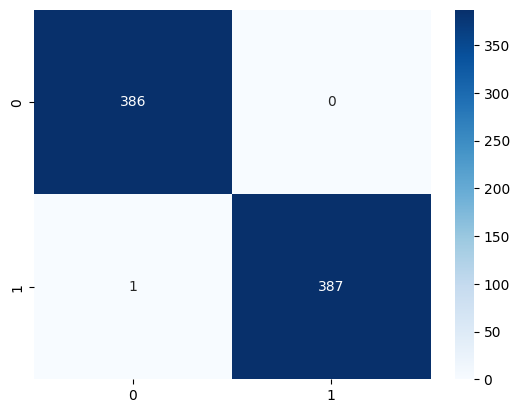

%Accuracy 0.9987080103359173


In [106]:
from sklearn.metrics import confusion_matrix
res = confusion_matrix(y_test, result)
bener = sum(y_test==result)
print('Confusion Matrix:\n')
sns.heatmap(res, annot=True, fmt="d", cmap="Blues")
plt.show()
print('%Accuracy', bener/len(y_test))
# Random Forest

In [107]:
from sklearn.metrics import classification_report
print(classification_report(y_test, result))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       386
           1       1.00      1.00      1.00       388

    accuracy                           1.00       774
   macro avg       1.00      1.00      1.00       774
weighted avg       1.00      1.00      1.00       774



# Asosiasi Kata

In [108]:
from gensim.models import Word2Vec

In [109]:
def tokenize(text: str):
  return text.split(' ')

token = df['Cleaned'].values.tolist()
token = list(map(lambda x: tokenize(x), token))
model_asosiasi = Word2Vec(sentences=token, vector_size=100, window=5, min_count=1, workers=4)

In [110]:
print(model_asosiasi.wv['so'])

[-9.4677590e-02  8.2047719e-01  9.4439276e-02  2.6220286e-01
  3.5294449e-01 -1.1200224e+00  4.5402446e-01  1.2829131e+00
 -6.3215250e-01 -4.3653542e-01 -1.6984314e-01 -1.1340243e+00
 -2.8571305e-01  2.6026013e-01  2.4788468e-01 -6.2313312e-01
  2.1251372e-01 -5.8703077e-01 -1.9768019e-01 -1.0743648e+00
  2.9997510e-01  1.9220918e-01  5.4985744e-01 -5.2074593e-01
 -8.2053714e-02  5.0258107e-02 -6.3473076e-01 -4.3676072e-01
 -4.1246742e-01  7.1306199e-02  4.6159631e-01  1.8542667e-03
  1.7031160e-01 -5.6300819e-01 -2.7754533e-01  6.7803842e-01
  5.7648987e-01 -5.5069637e-01 -2.5205657e-01 -1.0195301e+00
  1.1432272e-03 -6.8502897e-01 -1.2158890e-01  2.7280235e-01
  4.3449268e-01 -1.6521710e-01 -7.7089810e-01 -3.6832908e-01
  2.3438112e-01  2.7606186e-01  5.6043410e-01 -5.7468313e-01
 -2.1747062e-01 -3.1003919e-01 -4.5591953e-01  1.5280238e-01
  4.9199906e-01 -2.5636157e-01 -9.0630424e-01  1.7743608e-01
  9.8765537e-02  5.2222781e-02  1.6076568e-01  1.3173066e-01
 -4.4862512e-01  7.37277

In [116]:
similar_words = model_asosiasi.wv.most_similar('bruntusan', topn=10)
print(similar_words)

[('ku', 0.9995458126068115), ('muka', 0.9995402693748474), ('minyak', 0.9995132088661194), ('jarang', 0.9994658827781677), ('ngaruh', 0.99944669008255), ('parah', 0.9994407892227173), ('muncul', 0.9994239807128906), ('minggu', 0.999415397644043), ('beruntus', 0.999381959438324), ('benar', 0.9993613958358765)]


# Console Based Program

In [114]:
# user_txt = input('Type your review: ')
user_txt = [
  "Keren, jerawatku hilang dalam pemakaian rutin",
  "Bagus, beneran ngaruh di aku",
  "Sejauh ini sih belum kelihatan hasilnya",
  "Belum kelihatan hasilnya",
  "Ga rekomen sih",
  "Jelek banget",
  "Jelekk, di aku bikin jerawatan",
  "Nggak cocok di aku, bikin jerawatan. gak worth it",
  "Nggak cocok di kulitku",
  "Biasa aja gak ada efeknya di aku",
  "Habis pakai ini muncul jerawat",
  "Bikin jerawatan habis dipakai"
]
for i in range (len(user_txt)):
  user_txt[i] = preprocess(user_txt[i])
  print(user_txt[i])
user_tf = vectorizer.transform(user_txt)
user_tf.shape

# # Mendapatkan feature names (kata-kata yang di-vectorize)
# feature_names = vectorizer.get_feature_names_out()

# # Mendapatkan TF-IDF scores dari input pengguna
# user_tfidf_scores = user_tf.toarray()

# # Tampilkan hasil dalam bentuk DataFrame untuk memudahkan pembacaan
# tfidf_df = pd.DataFrame(user_tfidf_scores, columns=feature_names)

# # Transpos DataFrame agar kata-kata menjadi index dan skor menjadi kolom
# tfidf_df_transposed = tfidf_df.T

# # Beri nama kolom untuk lebih jelas
# tfidf_df_transposed.columns = ['tfidf_score']

# # Sort DataFrame berdasarkan skor TF-IDF dari besar ke kecil
# sorted_tfidf_df = tfidf_df_transposed.sort_values(by='tfidf_score', ascending=False)

# # bakal ada feature yang nilainya 0, yaitu yang nggak ada di input user. ini ttp ada di vector karena supaya ukurannya sama dengan ukuran vector training
# print(sorted_tfidf_df)

keren jerawat hilang pakai rutin
bagus benar ngaruh
sih hasil
hasil
tidak_rekomen sih
jelek banget
jelek bikin jerawat
tidak_cocok bikin jerawat tidak_worth
tidak_cocok kulit
tidak_efek
habis pakai muncul jerawat
bikin jerawat habis pakai


(12, 3000)

In [115]:
res_arr = model.predict(user_tf)

for res in res_arr:
  if (res == 1):
    print('Positif')
  else:
    print('Negatif')

# masih jelek x :(

Positif
Positif
Positif
Positif
Positif
Positif
Positif
Negatif
Negatif
Positif
Negatif
Negatif
